<a href="https://colab.research.google.com/github/alamau01/Thesis-in-EE/blob/master/Stock_Price_Prediction_LSTM_TensorFlow_Apple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 1.x
!pip show tensorflow

TensorFlow 1.x selected.
Name: tensorflow
Version: 1.15.2
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /tensorflow-1.15.2/python3.6
Requires: six, numpy, opt-einsum, gast, wrapt, grpcio, absl-py, wheel, keras-preprocessing, protobuf, tensorboard, termcolor, keras-applications, google-pasta, astor, tensorflow-estimator
Required-by: stable-baselines, magenta, fancyimpute


In [0]:
import pandas_datareader as web
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import tensorflow as tf

dataset = web.DataReader('AAPL', data_source = 'yahoo', start = '2000-01-01', end = '2020-03-31')
dataset

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2000-01-03,4.017857,3.631696,3.745536,3.997768,133949200.0,3.470226
2000-01-04,3.950893,3.613839,3.866071,3.660714,128094400.0,3.177650
2000-01-05,3.948661,3.678571,3.705357,3.714286,194580400.0,3.224152
2000-01-06,3.821429,3.392857,3.790179,3.392857,191993200.0,2.945139
2000-01-07,3.607143,3.410714,3.446429,3.553571,115183600.0,3.084645
...,...,...,...,...,...,...
2020-03-25,258.250000,244.300003,250.750000,245.520004,75900500.0,245.520004
2020-03-26,258.679993,246.360001,246.520004,258.440002,63021800.0,258.440002
2020-03-27,255.869995,247.050003,252.750000,247.740005,51054200.0,247.740005


                High       Low      Open     Close       Volume  Adj Close
Date                                                                      
2000-01-03  4.017857  3.631696  3.745536  3.997768  133949200.0   3.470226
2000-01-04  3.950893  3.613839  3.866071  3.660714  128094400.0   3.177650
2000-01-05  3.948661  3.678571  3.705357  3.714286  194580400.0   3.224152
2000-01-06  3.821429  3.392857  3.790179  3.392857  191993200.0   2.945139
2000-01-07  3.607143  3.410714  3.446429  3.553571  115183600.0   3.084645


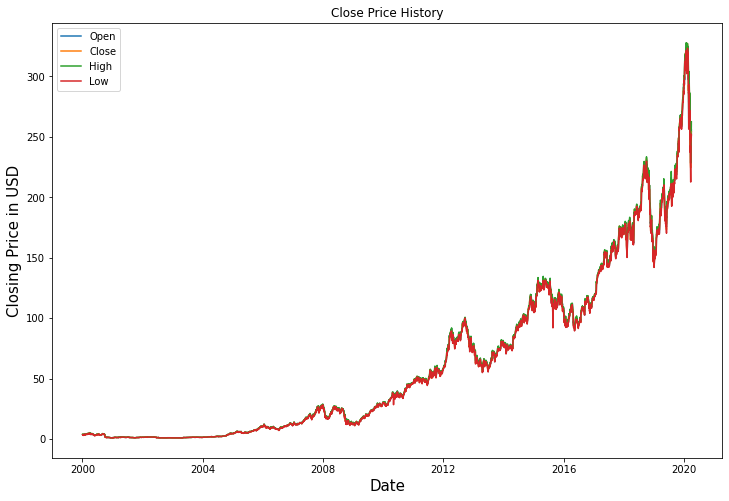

In [0]:
# Data Exploration
# Data is sorted by date since the order of the data is essential for time series models
apple_data = dataset.sort_values('Date')
print(apple_data.head())

#Data Visualization
plt.figure(figsize = (12, 8))
plt.plot(apple_data['Open'])
plt.plot(apple_data['Close'])
plt.plot(apple_data['High'])
plt.plot(apple_data['Low'])
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Closing Price in USD', fontsize = 15)
plt.title('Close Price History')
plt.legend(['Open', 'Close', 'High', 'Low'], loc = 'upper left')
plt.show()

In [0]:
from sklearn.preprocessing import MinMaxScaler

#Splitting data into training and test data sets
#high_prices = apple_data.loc[:,'High'].values
#low_prices = apple_data.loc[:,'Low'].values
#avg_prices = (high_prices+low_prices)/2.0
closing_stock_prices = apple_data.loc[:, 'Close'].values
data_train = closing_stock_prices[: 4022] # The first 4022 datapoints are taken as training samples
data_test = closing_stock_prices[4022 :] # The rest are taken as testing samples

# The datasets are scaled to be between 0 and 1. 
# Both test and train data are normalized with respect to the training dataset
# as the test data is not to be accessed
sc = MinMaxScaler()
data_train = data_train.reshape(-1, 1)
data_test = data_test.reshape(-1, 1)

#The scaler is trained with training and smooth data
smooth_window = 1000
for di in range(0, 4000, smooth_window):
  sc.fit(data_train[di : di + smooth_window, :])
  data_train[di : di + smooth_window, :] = sc.transform(data_train[di : di + smooth_window, :])

# The last bit of remaining data is normalized
sc.fit(data_train[di + smooth_window:, :])
data_train[di + smooth_window:, :] = sc.transform(data_train[di + smooth_window:, :])

# The data is reshaped back to the shape of [data_size]
data_train = data_train.reshape(-1)
data_test = sc.transform(data_test).reshape(-1)

In [0]:
# Exponential moving average is used for smoothing
# so that the data exhibits a smoother curve than the original erratic data
ema = 0.0
gamma = 0.1
for ti in range(4022):
  ema = gamma * data_train[ti] + (1 - gamma) * ema
  data_train[ti] = ema

# Used for visualization and test purposes
all_mid_data = np.concatenate([data_train, data_test], axis = 0)

In [0]:
class DataGeneratorSeq(object):

  def __init__(self, prices, batch_size, num_unroll):
    self._prices = prices
    self._prices_length = len(self._prices) - num_unroll
    self._batch_size = batch_size
    self._num_unroll = num_unroll
    self._segments = self._prices_length // self._batch_size
    self._cursor = [offset * self._segments for offset in range(self._batch_size)]

  def next_batch(self):
    batch_data = np.zeros((self._batch_size), dtype = np.float32)
    batch_labels = np.zeros((self._batch_size), dtype = np.float32)

    for b in range(self._batch_size):
      if self._cursor[b] + 1 >= self._prices_length:
        self._cursor[b] = np.random.randint(0, (b + 1) * self._segments)

      batch_data[b] = self._prices[self._cursor[b]]
      batch_labels[b] = self._prices[self._cursor[b] + np.random.randint(0, 5)]

      self._cursor[b] = (self._cursor[b] + 1) %self._prices_length

    return batch_data, batch_labels

  def unroll_batches(self):
    unroll_data, unroll_labels = [], []
    init_data, init_label = None, None
    for ui in range(self._num_unroll):
      data, labels = self.next_batch()
      unroll_data.append(data)
      unroll_labels.append(labels)

    return unroll_data, unroll_labels

  def reset_indices(self):
    for b in range(self._batch_size):
      self._cursor[b] = np.random.randint(0, min((b + 1) * self._segments, self._prices_length - 1))

datagenerator = DataGeneratorSeq(data_train, 5, 5)
u_data, u_labels = datagenerator.unroll_batches()

for ui, (dat, lbl) in enumerate(zip(u_data, u_labels)):
  print('\n\nUnrolled index %d' %ui)
  dat_ind = dat
  lbl_ind = lbl
  print('\tInputs: ', dat)
  print('\n\tOutput: ', lbl)



Unrolled index 0
	Inputs:  [0.07265732 0.02625005 0.3038524  0.22207421 0.5237695 ]

	Output:  [0.18297036 0.02672812 0.3038524  0.22799225 0.5020513 ]


Unrolled index 1
	Inputs:  [0.13004747 0.02672812 0.30279672 0.22525628 0.51792914]

	Output:  [0.29713586 0.02709056 0.29444435 0.2324731  0.51792914]


Unrolled index 2
	Inputs:  [0.18297036 0.02709056 0.3014225  0.22799225 0.5135894 ]

	Output:  [0.22297044 0.02756936 0.29891878 0.23010582 0.5020513 ]


Unrolled index 3
	Inputs:  [0.22297044 0.02756936 0.29891878 0.23010582 0.5073632 ]

	Output:  [0.29713586 0.02693201 0.29891878 0.23553552 0.4974285 ]


Unrolled index 4
	Inputs:  [0.2627858  0.02693201 0.29587698 0.2324731  0.5020513 ]

	Output:  [0.32381177 0.02666361 0.29587698 0.2324731  0.49818537]


In [0]:
# Defining the Hyperparameters
Dim = 1 # Dimensionality of the data
num_unrollings = 400 # Number of time steps looked into the future, i.e. 50 days into the future
batch_size = 1000 # Number of samples in a batch
num_nodes = [300, 300, 250] # Number of hidden nodes
n_layers = len(num_nodes) # Number of layers
dropout = 0.2 

tf.reset_default_graph() # Essential for running this multiple times

# Input Data
in_train, out_train = [], []

# The input is unrolled over time defining placeholders for each time step
for ui in range(num_unrollings):
  in_train.append(tf.placeholder(tf.float32, shape = [batch_size, Dim], name = 'in_train_%d' %ui))
  out_train.append(tf.placeholder(tf.float32, shape = [batch_size, 1], name = 'out_train_%d' %ui))

# Defining parameters of the LSTM and regression layer
cells_LSTM = [
    tf.contrib.rnn.LSTMCell(num_units=num_nodes[li],
                            state_is_tuple=True,
                            initializer= tf.contrib.layers.xavier_initializer()
                           )
 for li in range(n_layers)]

cells_drop_LSTM = [tf.contrib.rnn.DropoutWrapper(
    lstm, input_keep_prob = 1.0, output_keep_prob = 1.0 - dropout, state_keep_prob = 1.0 - dropout
) for lstm in cells_LSTM]

drop_multi_cell = tf.contrib.rnn.MultiRNNCell(cells_drop_LSTM)
multi_cell = tf.contrib.rnn.MultiRNNCell(cells_LSTM)

w = tf.get_variable('w', shape = [num_nodes[-1], 1], initializer = tf.contrib.layers.xavier_initializer())
b = tf.get_variable('b', initializer = tf.random_uniform([1], -0.1, 0.1))

# Calculating the LSTM output for the regression layer to output the final prediction
# Creating cell state and hidden state variables to maintain the state of the LSTM
c, h = [], []
ini_state = []
for li in range(n_layers):
  c.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable = False))
  h.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable = False))
  ini_state.append(tf.contrib.rnn.LSTMStateTuple(c[li], h[li]))

# Several tensor transformations are performed as the dynamic_rnn function
# needs the output to be of a particular format.
all_in = tf.concat([tf.expand_dims(t, 0) for t in in_train], axis = 0)
all_LSTM_out, state = tf.nn.dynamic_rnn(
    drop_multi_cell, all_in, initial_state = tuple(ini_state),
    time_major = True, dtype = tf.float32)

all_LSTM_out = tf.reshape(all_LSTM_out, [batch_size * num_unrollings, num_nodes[-1]])
all_out = tf.nn.xw_plus_b(all_LSTM_out, w,b)
split_out = tf.split(all_out, num_unrollings, axis = 0)

# Loss Calculation and Optimizer
print('Define training loss')
loss = 0.0
with tf.control_dependencies([tf.assign(c[li], state[li][0]) for li in range(n_layers)]+
                             [tf.assign(h[li], state[li][1]) for li in range(n_layers)]):
  for ui in range(num_unrollings):
    loss += tf.reduce_mean(0.5 * (split_out[ui] - out_train[ui]) ** 2)

print('Learning rate decay operations')
glbl_step = tf.Variable(0, trainable = False)
inc_gstep = tf.assign(glbl_step, glbl_step + 1)
tf_lrn_rate = tf.placeholder(shape = None, dtype = tf.float32)
tf_min_lrn_rate = tf.placeholder(shape = None, dtype = tf.float32)

lrn_rate = tf.maximum(tf.train.exponential_decay(tf_lrn_rate, glbl_step, decay_steps = 1, decay_rate = 0.5, staircase = True), tf_min_lrn_rate)

#Optimizer
print('TF Optimization Operations')
optimizer = tf.train.AdamOptimizer(lrn_rate)
grad, v = zip(*optimizer.compute_gradients(loss))
grad, _ = tf.clip_by_global_norm(grad, 5.0)
optimizer = optimizer.apply_gradients(zip(grad, v))
print('\tAll done')

# Prediction related calculations
print('Define prediction related TF functions')

sample_in = tf.placeholder(tf.float32, shape = [1, Dim])

# Maintaining the LSTM state for predictions:
c_smple, h_smple, ini_state_smple = [], [], []
for li in range(n_layers):
  c_smple.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable = False))
  h_smple.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable = False))
  ini_state_smple.append(tf.contrib.rnn.LSTMStateTuple(c_smple[li], h_smple[li]))

reset_states_smple = tf.group(*[tf.assign(c_smple[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)],
                               *[tf.assign(h_smple[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)])

sample_out, state_smple = tf.nn.dynamic_rnn(multi_cell, tf.expand_dims(sample_in, 0),
                                   initial_state=tuple(ini_state_smple),
                                   time_major = True,
                                   dtype=tf.float32)

with tf.control_dependencies([tf.assign(c_smple[li], state_smple[li][0]) for li in range(n_layers)]+
                              [tf.assign(h_smple[li], state_smple[li][1]) for li in range(n_layers)]):  
  pred_sample = tf.nn.xw_plus_b(tf.reshape(sample_out, [1,-1]), w, b)

print('\tAll done')


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Define training loss
Learning rate decay operations
TF Optimization Operations
Instr

In [0]:
# Running the LSTM
epochs = 10
valid_sum = 1 # Interval of test predictions
n_pred_once = 50 # Number of steps to continuously predict for
train_seq_len = data_train.size # Full length of the training data
mse_train_ot = [] # Accumulate train losses
mse_test_ot = [] # Accumulate test losses
pred_ot = [] # Accumulate predictions
sesh = tf.InteractiveSession()
tf.global_variables_initializer().run()

# Applied for decaying learning rate
loss_nondec_count = 0
loss_nondec_thresh = 2 

print('Initialized')
avg_loss = 0

# Defining Data Generator
data_gen = DataGeneratorSeq(data_train, batch_size, num_unrollings)
x_axis_seq = []

# Points where the predictions are started from
test_pnts_seq = np.arange(4022, 5022, 50).tolist()

for epoch in range(epochs):
  # ========================= Training ===========================
  for step in range(train_seq_len // batch_size):
    u_data, u_labels = data_gen.unroll_batches()

    feed_dict = {}
    for ui, (dat, lbl) in enumerate(zip(u_data, u_labels)):
      feed_dict[in_train[ui]] = dat.reshape(-1, 1)
      feed_dict[out_train[ui]] = lbl.reshape(-1, 1)

    feed_dict.update({tf_lrn_rate: 0.0001, tf_min_lrn_rate: 0.000001})
    _, l = sesh.run([optimizer, loss], feed_dict = feed_dict)
    avg_loss += l

  # ======================== Validation ==========================
  if (epoch + 1) % valid_sum == 0:
    avg_loss = avg_loss / (valid_sum * (train_seq_len // batch_size))

    # The average loss
    if (epoch + 1) % valid_sum == 0:
      print('Average loss at step %d: %f' %(epoch + 1, avg_loss))

      mse_train_ot.append(avg_loss)

      avg_loss = 0 # Reset loss

      pred_seq = []

      mse_test_loss_seq = []

      # ==================== Updating State and Making Predictions ==================
      for wi in test_pnts_seq:
        mse_test_loss = 0.0
        our_pred = []

        if (epoch + 1) - valid_sum == 0:
          # Only x_axis values are computed in the first validation epoch
          x_axis = []

        # Recent past behavior of stock prices are fed
        # to make predictions from that point onwards
        for tri in range(wi - num_unrollings + 1, wi - 1):
          current_price = all_mid_data[tri]
          feed_dict[sample_in] = np.array(current_price).reshape(1, 1)
          _ = sesh.run(pred_sample, feed_dict = feed_dict)

        feed_dict = {}
        current_price = all_mid_data[wi - 1]
        feed_dict[sample_in] = np.array(current_price).reshape(1, 1)

        # Prediction are made for this many steps
        # Each prediction uses previous prediction as its current input
        for predi in range(n_pred_once):
          pred = sesh.run(pred_sample, feed_dict = feed_dict)
          our_pred.append(np.asscalar(pred))
          feed_dict[sample_in] = np.asarray(pred).reshape(-1, 1)

          if (epoch + 1) - valid_sum == 0:
            # Only x_axis values in the first validation epoch are calculated
            x_axis.append(wi + predi)

          mse_test_loss += 0.5 * (pred - all_mid_data[wi + predi]) ** 2

        sesh.run(reset_states_smple)
        pred_seq.append(np.array(our_pred))
        mse_test_loss /= n_pred_once
        mse_test_loss_seq.append(mse_test_loss)

        if (epoch + 1) - valid_sum == 0:
          x_axis_seq.append(x_axis)

      current_test_mse = np.mean(mse_test_loss_seq)

      # Learning rate decay logic
      if len(mse_test_ot) > 0 and current_test_mse > min(mse_test_ot):
        loss_nondec_count += 1
      else:
        loss_nondec_count = 0

      if loss_nondec_count > loss_nondec_thresh:
        sesh.run(inc_gstep)
        loss_nondec_count = 0
        print('\tDecreasing learning rate by 0.5')

      mse_test_ot.append(current_test_mse)
      print('\tTest MSE: %.5f' %np.mean(mse_test_loss_seq))
      pred_ot.append(pred_seq)
      print('\tFinished Predictions')


/tensorflow-1.15.2/python3.6/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Initialized
Average loss at step 1: 17.407263


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:79: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


	Test MSE: 12.17741
	Finished Predictions
Average loss at step 2: 6.501439
	Test MSE: 7.27803
	Finished Predictions
Average loss at step 3: 4.130469
	Test MSE: 5.01573
	Finished Predictions
Average loss at step 4: 5.034505
	Test MSE: 6.46429
	Finished Predictions
Average loss at step 5: 1.805846
	Test MSE: 8.16809
	Finished Predictions
Average loss at step 6: 1.566873
	Decreasing learning rate by 0.5
	Test MSE: 5.83430
	Finished Predictions
Average loss at step 7: 1.502710
	Test MSE: 5.26025
	Finished Predictions
Average loss at step 8: 1.320725
	Test MSE: 5.61890
	Finished Predictions
Average loss at step 9: 1.056769
	Decreasing learning rate by 0.5
	Test MSE: 5.86799
	Finished Predictions
Average loss at step 10: 0.938864
	Test MSE: 5.15138
	Finished Predictions


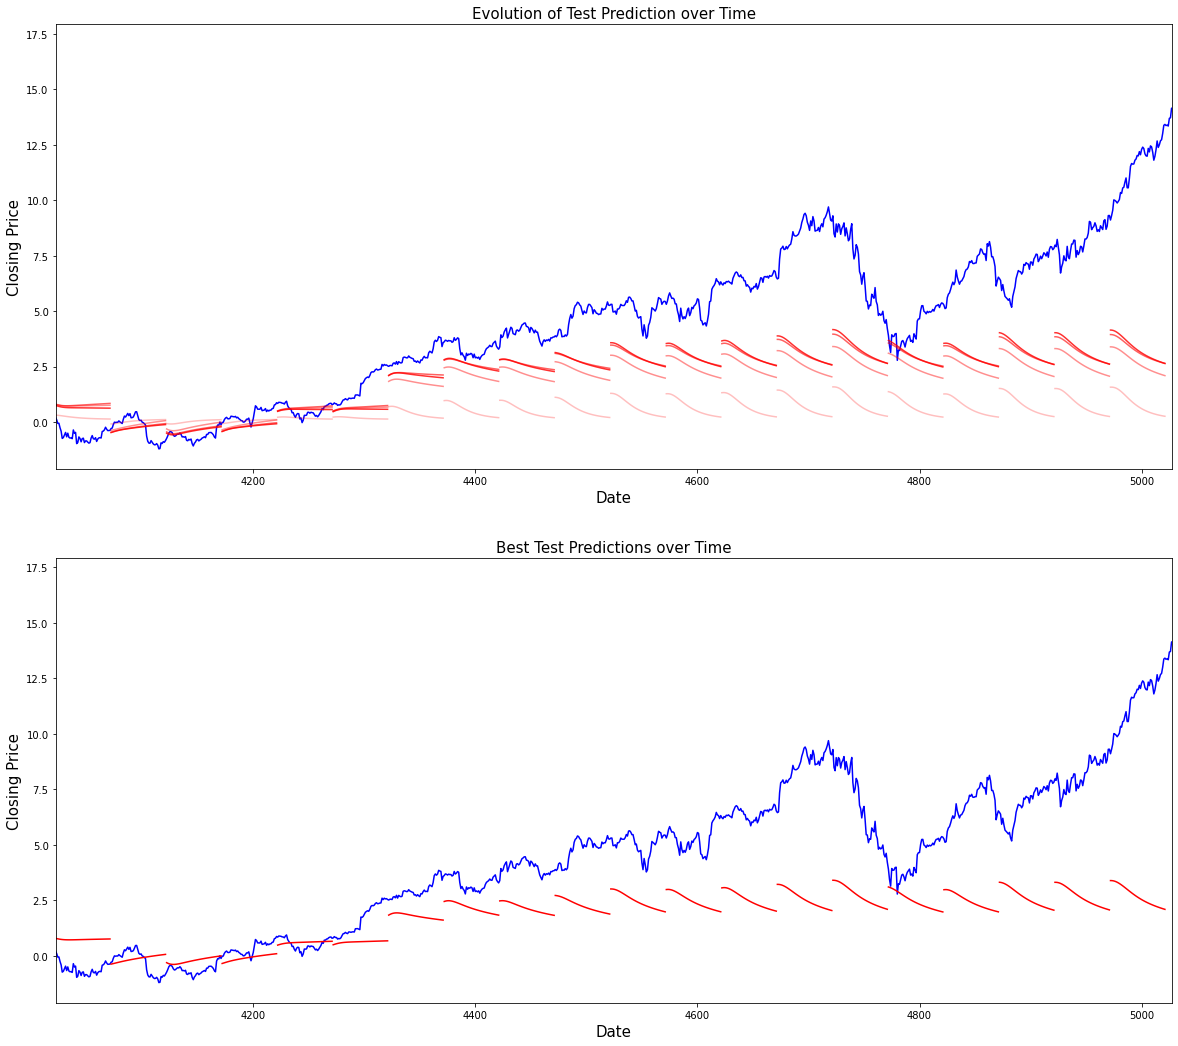

2.127310196385071
4075
4022
50
1071
10
20
1


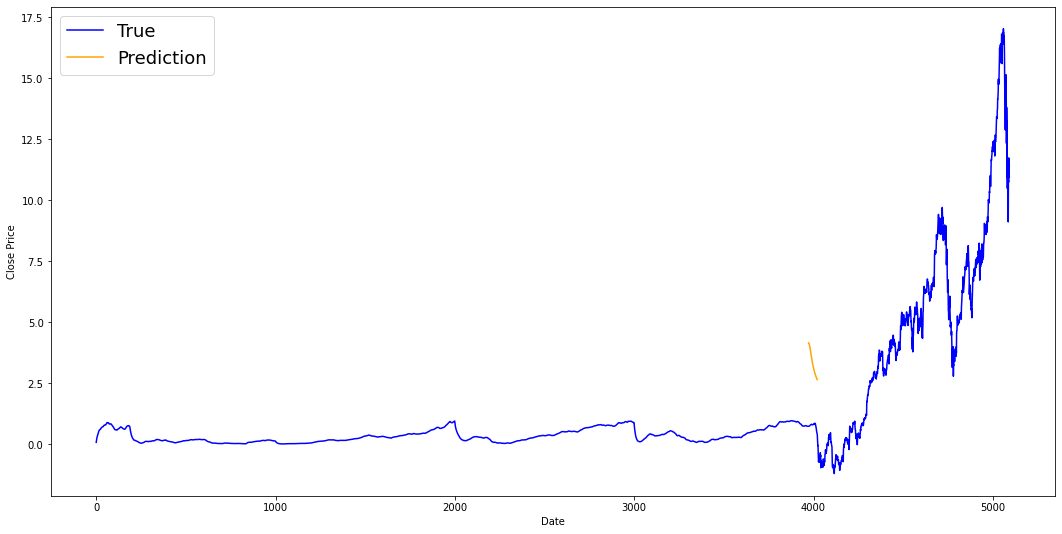

In [0]:
import matplotlib.pyplot as plt

best_pred_epoch = 3
rmse_score = np.sqrt(np.mean(((pred_ot[best_pred_epoch] - data_test[best_pred_epoch]) ** 2)))

plt.figure(figsize = (20, 18))
plt.subplot(2, 1, 1)
plt.plot(range(dataset.shape[0]), all_mid_data, color = 'b')

start_alpha = 0.25
alpha = np.arange(start_alpha, 1.1, (1.0 - start_alpha) / len(pred_ot[::3]))
for pi, p in enumerate(pred_ot[::3]):
  for xval, yval in zip(x_axis_seq, p):
    plt.plot(xval, yval, color = 'r', alpha = alpha[pi])

plt.title('Evolution of Test Prediction over Time', fontsize = 15)
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Closing Price', fontsize = 15)
plt.xlim(4022, 5027)

plt.subplot(2, 1, 2)

plt.plot(range(dataset.shape[0]), all_mid_data, color = 'b')
for xval, yval in zip(x_axis_seq, pred_ot[best_pred_epoch]):
  plt.plot(xval, yval, color = 'r')

plt.title('Best Test Predictions over Time', fontsize = 15)
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Closing Price', fontsize = 15)
plt.xlim(4022, 5027)
plt.show()
print(rmse_score)

import math
data_train_len = math.ceil(len(closing_stock_prices) * .8)
#train = dataset.filter(['Close'])[: data_train_len]
valid = dataset.filter(['Close'])[len(data_train) :]
#valid['Predictions'] = our_pred

print(data_train_len)
print(len(data_train))
print(len(our_pred))
print(len(valid))
print(len(pred_ot))
print(len(pred_seq))
print(len(pred))

'''plt.figure(figsize = (12, 8))
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Closing Price in USD')
plt.legend(['Train', 'Val', 'Predictions'], loc = 'lower right')
plt.title('Model')
plt.show()'''

plt.figure(figsize = (18,9))
plt.plot(range(apple_data.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(3972,data_train.size),our_pred,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend(fontsize=18)
plt.show()